In [17]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
imNum = 1
impath = 'trash_img'
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (16, 10)
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(X, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [2]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf")
x = df.iloc[:, 0].dropna()
y = df.iloc[:, 1].dropna()
xerr = 0.1
yerr = 1


# x = np.array([
# 256.0,361.0,484.0,625.0,784.0,961.0,1156.0,1521.0,1764.0,2025.0,2304.0,169.0
# ])
# y = np.array([
# 40.474485,44.28800000000001,48.672000000000004,53.59786801199999,59.56816728,66.195521388,73.25249903999999,86.71392784400001,95.503225823,105.05186009,115.60976497600001,36.62553387599999
# ])
# xerr = np.array([
# 32.0,38.0,44.0,50.0,56.0,62.0,68.0,78.0,84.0,90.0,96.0,26.0
# ])
# yerr = np.array([
# 3.2584050000000007,3.113600000000001,3.0576000000000003,3.05875596,3.1154905600000005,3.2047047600000003,3.3160478399999995,3.5470028900000004,3.70314741,3.8748144900000008,4.058298240000001,3.569614409999999
# ])


In [3]:
df.iloc[:, 0].dropna()

0    10.0
1    11.0
2    12.0
3    13.0
4    14.0
Name: R, om, dtype: float64

In [13]:
#xi square approximation with Y-errors
%matplotlib inline
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
par_names_str = r'''
$\frac{dR}{dt}$, $\frac{\Omega}{c}$
b, $\Omega$
'''
# function to approximate
fun_name = r"$f(x) = \frac{dR/dt}t + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

from scipy.optimize import curve_fit


0.8108108108103986 +- 0.25993762144133364
8.918918918936193 +- 1.0842857796678644
аппроксимация функцией $f(x) = \frac{dR/dt}t + b$
$\frac{dR}{dt}$ = (800 ± 300)$\cdot 10^{-3}$ $\frac{\Omega}{c}$
b = 8.9 ± 1.1 $\Omega$


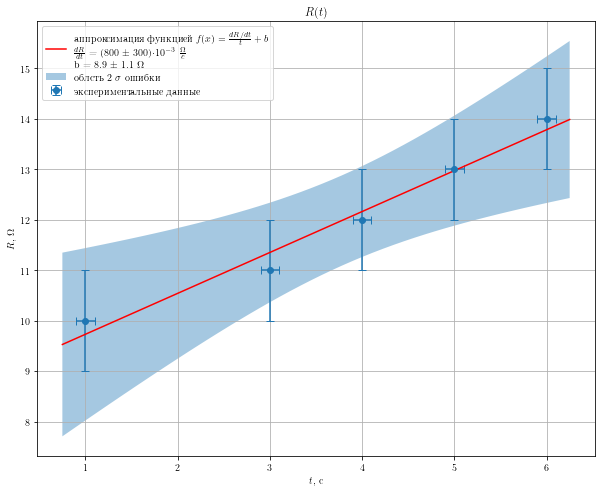

In [14]:
N = 0 # номер измерения

x = df.iloc[:, 3*N+1].dropna()
y = df.iloc[:, 3*N+0].dropna()
xerr = np.ones_like(x)*0.1
yerr = np.ones_like(x)*1

popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
print(approx_label)

plt.figure(figsize=(10, 8))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")
plt.legend()

plt.savefig(f"{impath}{imNum}.png", dpi=300)
# plt.savefig(f"name.png", dpi=300)
imNum+=1

0.8893442622948401 +- 0.1693768711947204
8.680327868869217 +- 0.9053574615341157
аппроксимация функцией $f(x) = \frac{dR/dt}t + b$
$\frac{dR}{dt}$ = (890 ± 170)$\cdot 10^{-3}$ $\frac{\Omega}{c}$
b = 8.7 ± 0.9 $\Omega$


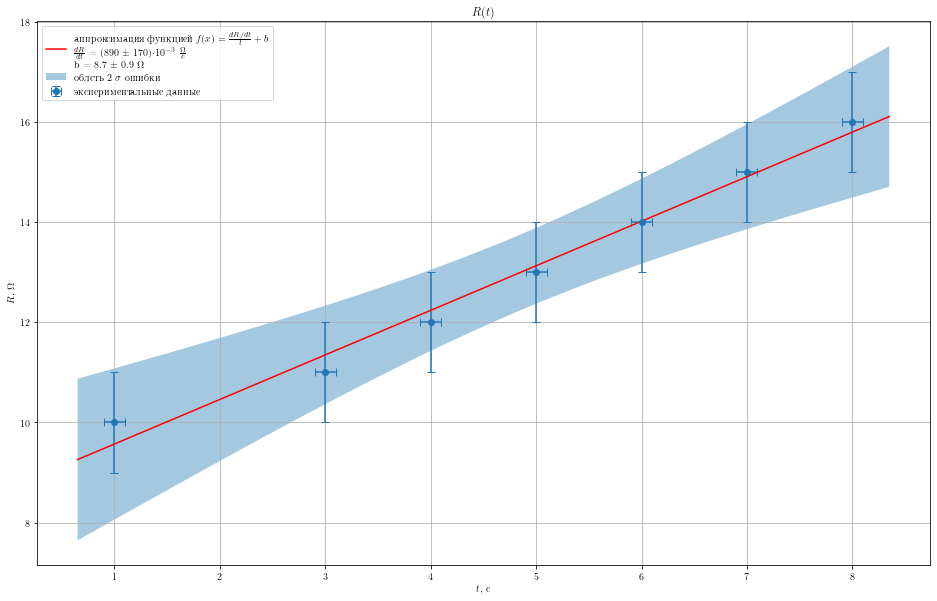

In [19]:
N = 1 # номер измерения

x = df.iloc[:, 3*N+1].dropna()
y = df.iloc[:, 3*N+0].dropna()
xerr = np.ones_like(x)*0.1
yerr = np.ones_like(x)*1

popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
print(approx_label)

# plt.figure(figsize=(10, 8))
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(r"$t$, c")
plt.ylabel(r"$R$, $\Omega$")
plt.title(r"$R(t)$")
plt.legend()

plt.savefig(f"{impath}{imNum}.png", dpi=300)
imNum+=1